In [63]:
#standard ds imports
import pandas as pd
import numpy as np

#viz and stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

import os
import env
import wrangle
import explore 
import modeling

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer # now that our data is split we can scale it
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import TweedieRegressor


# Acquire

In [64]:
df = wrangle.get_zillow_data() # from imports  

df.head(3)

,propertylandusedesc,parcelid,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips,logerror,transactiondate
0,Single Family Residential,11007640,3.0,2.0,1572.0,305307.0,1976.0,3887.80,6037.0,0.020360,2017-01-12
1,Single Family Residential,10821119,2.0,2.0,1430.0,381638.0,1952.0,4692.27,6037.0,0.025629,2017-01-03
2,Single Family Residential,17173851,4.0,2.0,1848.0,64712.0,1952.0,781.00,6111.0,0.088469,2017-01-03


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2152985 entries, 0 to 2152984
Data columns (total 11 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   propertylandusedesc           object 
 1   parcelid                      int64  
 2   bedroomcnt                    float64
 3   bathroomcnt                   float64
 4   calculatedfinishedsquarefeet  float64
 5   taxvaluedollarcnt             float64
 6   yearbuilt                     float64
 7   taxamount                     float64
 8   fips                          float64
 9   logerror                      float64
 10  transactiondate               object 
dtypes: float64(8), int64(1), object(2)
memory usage: 180.7+ MB


# Prepare 

In [66]:
from wrangle import prep_zillow # imports 

df = prep_zillow(df)

df.head(3)

,propertylandusedesc,parcel_id,bed_rooms,bath_rooms,finished_sqft,tax_value,year_built,tax_amount,county,log_error,transaction_date
0,Single Family Residential,11007640,3,2.0,1572,305307,1976,3887.80,6037,0.020360,2017-01-12
1,Single Family Residential,10821119,2,2.0,1430,381638,1952,4692.27,6037,0.025629,2017-01-03
2,Single Family Residential,17173851,4,2.0,1848,64712,1952,781.00,6111,0.088469,2017-01-03


# Split Data

In [67]:
from wrangle import split_data, view_split # import 

train, validate, test = split_data(df)

view_split(train, validate, test)

train    -> (29248, 11)
validate -> (12536, 11)
test     -> (10447, 11)


# Explore

# Question
## Does year built infuance tax value? 

In [68]:
train.year_built.describe()

count    29248.000000
mean      1963.336194
std         23.227765
min       1882.000000
25%       1950.000000
50%       1960.000000
75%       1979.000000
max       2016.000000
Name: year_built, dtype: float64

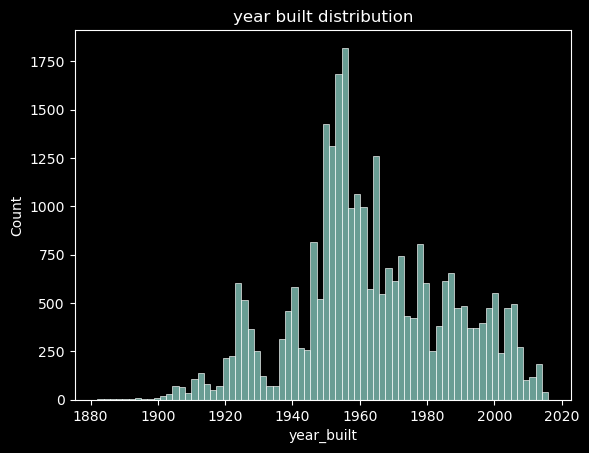

In [69]:
sns.histplot(data=train, x='year_built')
plt.title('year built distribution')
plt.show()

### Note 
- shows the distrobution of year built 

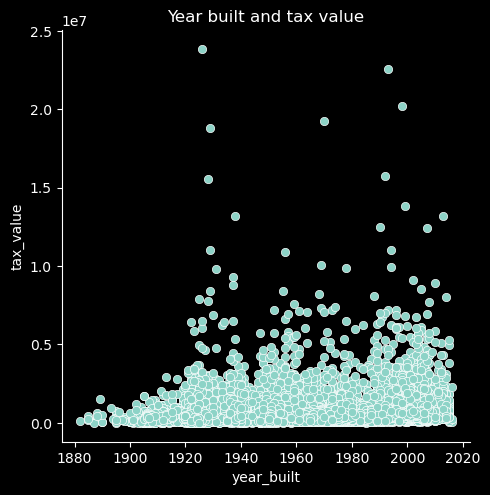

In [70]:
sns.relplot(x='year_built', y="tax_value", data=train)
plt.title('Year built and tax value')
plt.show()

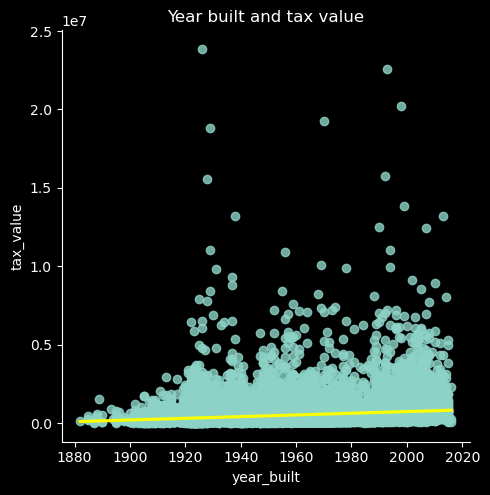

In [71]:
sns.lmplot(x='year_built', y="tax_value", data=train, line_kws={'color': 'yellow'})
plt.title('Year built and tax value')
plt.show()

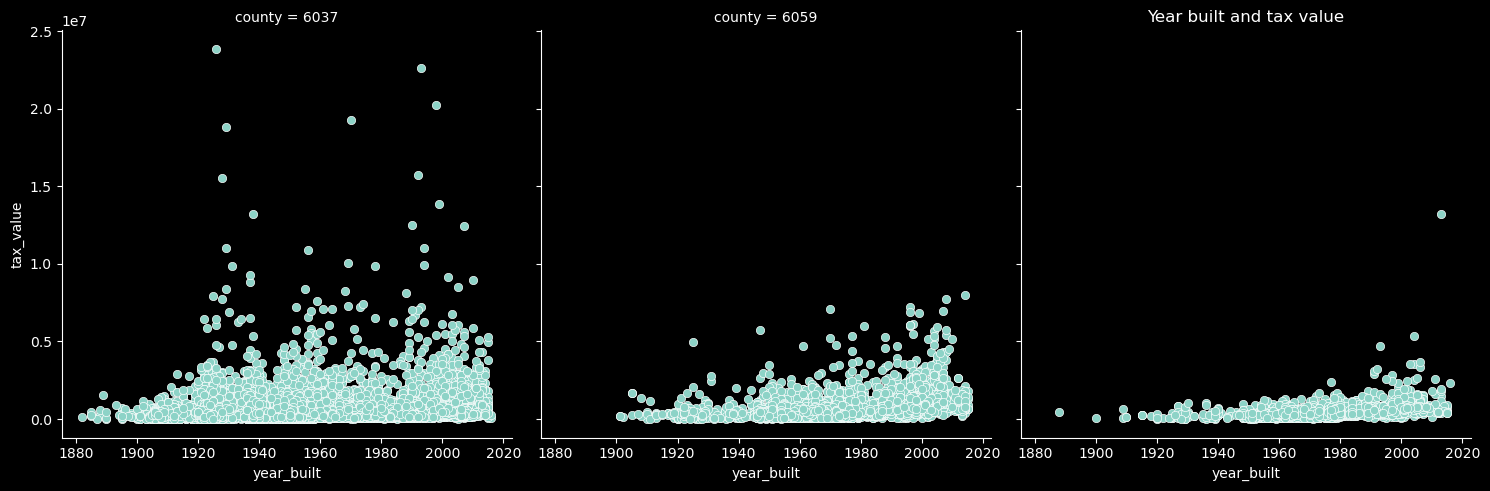

In [72]:
sns.relplot(x='year_built', y="tax_value", data=train, col='county')
plt.title('Year built and tax value')
plt.show()

In [73]:
mean_year_built_per_county = train.groupby('county')['year_built'].mean().reset_index()

mean_year_built_per_county

,county,year_built
0,6037,1957.083145
1,6059,1974.549910
2,6111,1976.361861


### Note 
- ploted the tax value and year built to see if there is a relationship

- year built is descrete
- tax value is continues 
- there is some sort of linear relationship between the two 

- we will have to use persons r

### Stats Test 
    
    Null - there is no linear correlation between year built and tax value 
    Alt - there is a linear correlation between year built and tax value 

In [74]:
from scipy import stats # imports 

alpha = 0.05 # set the alpha 


corr, p = stats.pearsonr(train.tax_value, train.year_built) # get the p value 
print(f'corr -> {corr}')
print(f'pvalue -> {p}')

if p < alpha: # compair p value our alpha value 
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

# Will be adding year built to my data dictionary 

corr -> 0.1754305734557165
pvalue -> 8.045703919385603e-201
We reject the null hypothesis


# Question 

## Do number of bedrooms impact tax value? 

In [75]:
train.bed_rooms.describe()

count    29248.000000
mean         3.306824
std          0.930052
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max          9.000000
Name: bed_rooms, dtype: float64

Text(0.5, 1.0, 'Distrobution of bedrooms')

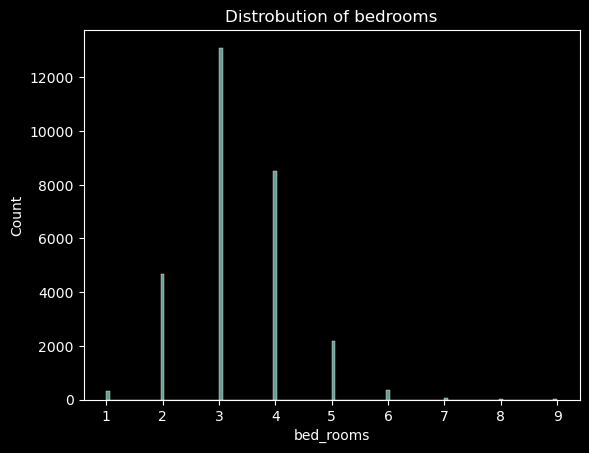

In [76]:
sns.histplot(data=train, x='bed_rooms')
plt.title('Distrobution of bedrooms')

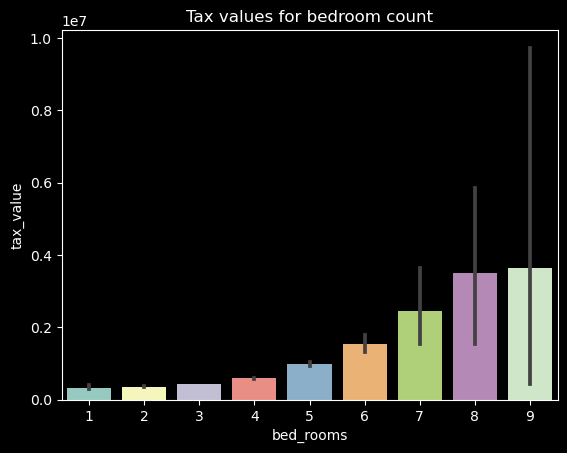

In [77]:
sns.barplot(data=train, x='bed_rooms', y='tax_value')
plt.title('Tax values for bedroom count')
plt.show()

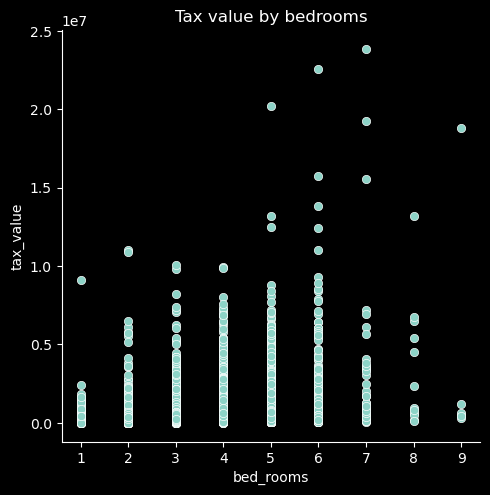

In [78]:
sns.relplot(x='bed_rooms', y="tax_value", data=train)
plt.title('Tax value by bedrooms')
plt.show()


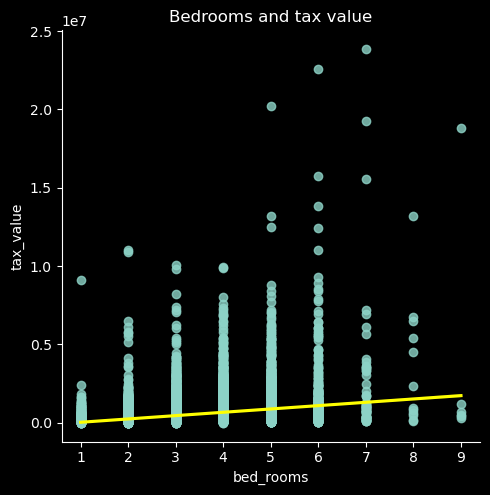

In [79]:
sns.lmplot(x='bed_rooms', y="tax_value", data=train, line_kws={'color': 'yellow'})
plt.title('Bedrooms and tax value')
plt.show()

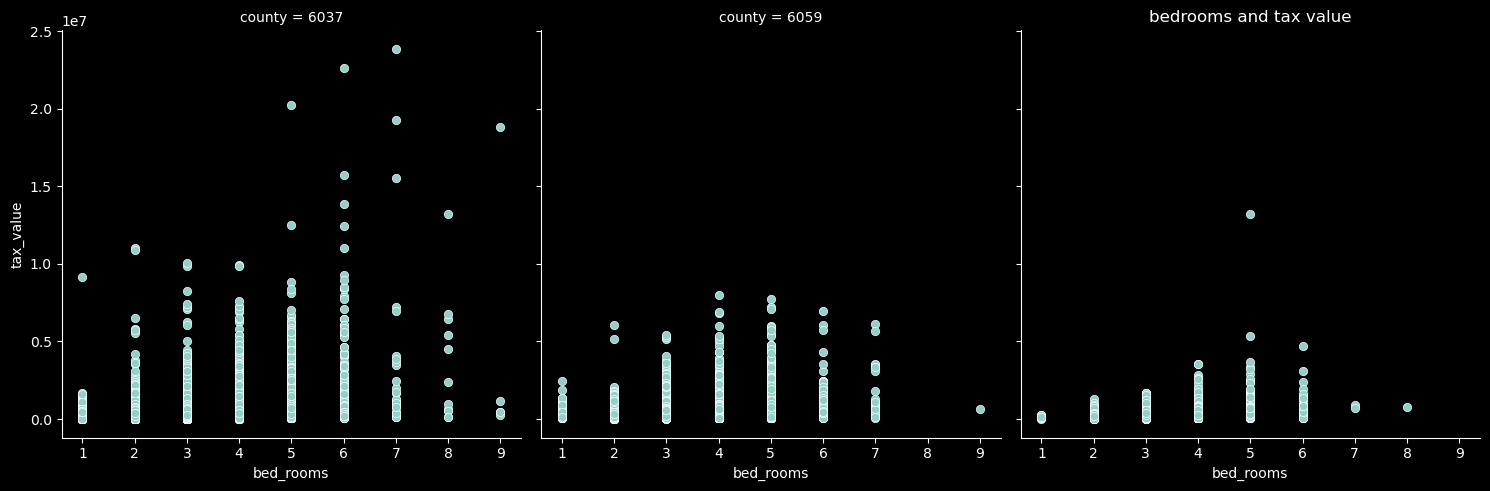

In [80]:
sns.relplot(x='bed_rooms', y="tax_value", data=train, col='county')
plt.title('bedrooms and tax value')
plt.show()

In [81]:
mean_bed_rooms_per_county = train.groupby('county')['bed_rooms'].mean().reset_index()

mean_bed_rooms_per_county

,county,bed_rooms
0,6037,3.201188
1,6059,3.478628
2,6111,3.584130


     Note 
- bedrooms is descrete
- tax value is continues 
- there is some sort of linear relationship between the two 

- we will have to use persons r

# Stats Test 
    
    Null - there is no linear correlation between bedrooms and tax value 
    Alt - there is a linear correlation between bedrooms and tax value 

In [82]:
from scipy import stats # imports 

alpha = 0.05 # set the alpha 


corr, p = stats.pearsonr(train.tax_value, train.bed_rooms) # get the p value 
print(f'corr -> {corr}')
print(f'pvalue -> {p}')

if p < alpha: # compair p value our alpha value 
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

# Will be adding year built to my data dictionary 

corr -> 0.2780996705042802
pvalue -> 0.0
We reject the null hypothesis


# Question 

## Do number of bathrooms impact tax value? 

In [83]:
train.bath_rooms.describe()

count    29248.000000
mean         2.301781
std          1.011686
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         10.000000
Name: bath_rooms, dtype: float64

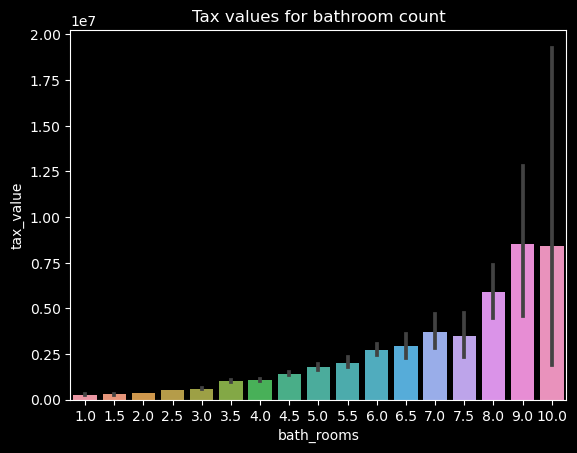

In [84]:
sns.barplot(data=train, x='bath_rooms', y='tax_value')
plt.title('Tax values for bathroom count')
plt.show()

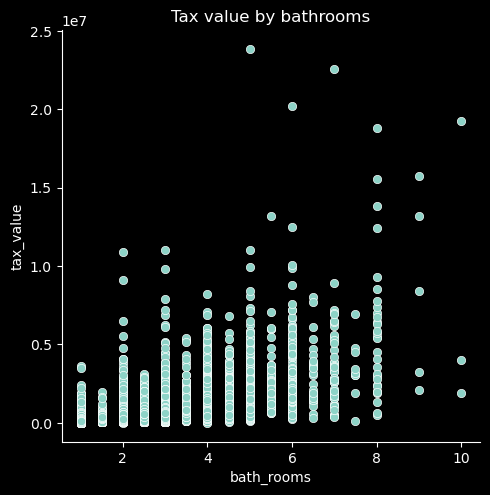

In [85]:
sns.relplot(data=train, y='tax_value', x='bath_rooms')
plt.title('Tax value by bathrooms')
plt.show()

Text(0.5, 1.0, 'Distrobution of bathrooms')

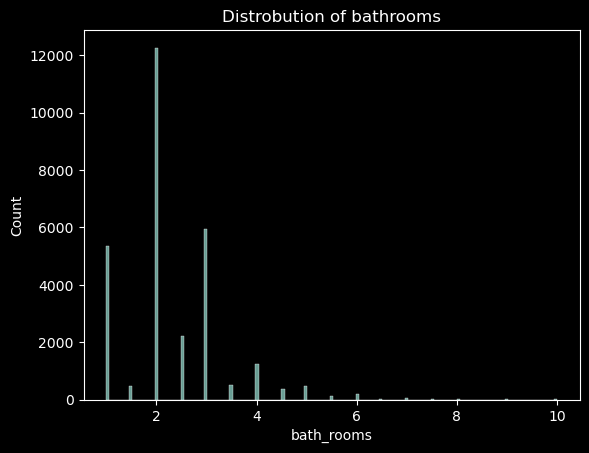

In [128]:
sns.histplot(data=train, x='bath_rooms')
plt.title('Distrobution of bathrooms')

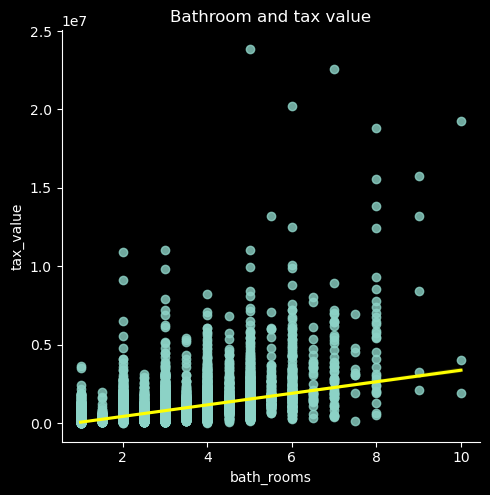

In [86]:
sns.lmplot(x='bath_rooms', y="tax_value", data=train, line_kws={'color': 'yellow'})
plt.title('Bathroom and tax value')
plt.show()

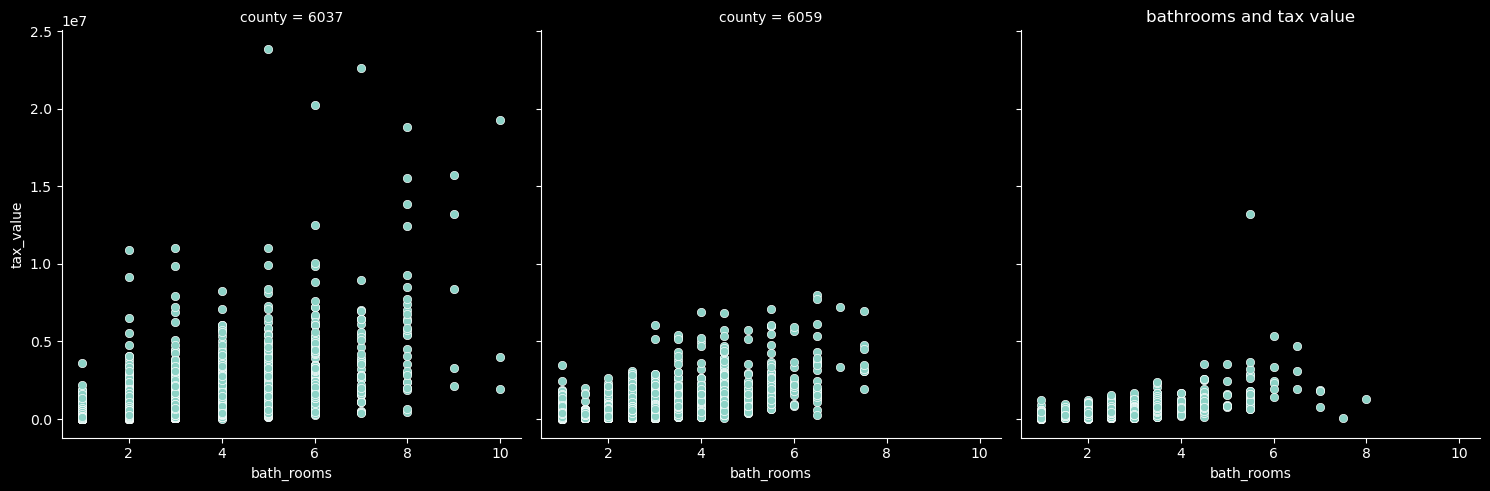

In [87]:
sns.relplot(x='bath_rooms', y="tax_value", data=train, col='county')
plt.title('bathrooms and tax value')
plt.show()

In [88]:
mean_bath_rooms_per_county = train.groupby('county')['bath_rooms'].mean().reset_index()

mean_bath_rooms_per_county

,county,bath_rooms
0,6037,2.188206
1,6059,2.519068
2,6111,2.494184


# Stats Test 
    
    Null - there is no linear correlation between bathrooms and tax value 
    Alt - there is a linear correlation between bathrooms and tax value 

In [89]:
from scipy import stats # imports 

alpha = 0.05 # set the alpha 


corr, p = stats.pearsonr(train.tax_value, train.bath_rooms) # get the p value 
print(f'corr -> {corr}')
print(f'pvalue -> {p}')

if p < alpha: # compair p value our alpha value 
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

# Will be adding year built to my data dictionary 

corr -> 0.5245002033631303
pvalue -> 0.0
We reject the null hypothesis


# Question 
### Does finished sqft impact tax value? 

In [127]:
train.finished_sqft.describe()

count    29248.000000
mean      1918.112760
std        986.764401
min        152.000000
25%       1265.000000
50%       1656.000000
75%       2302.000000
max      13598.000000
Name: finished_sqft, dtype: float64

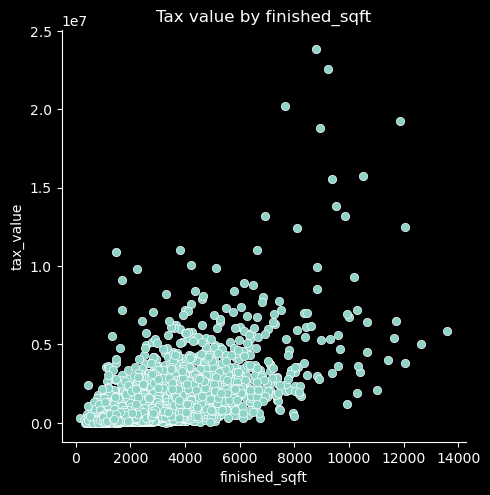

In [91]:
sns.relplot(data=train, y='tax_value', x='finished_sqft')
plt.title('Tax value by finished_sqft')
plt.show()

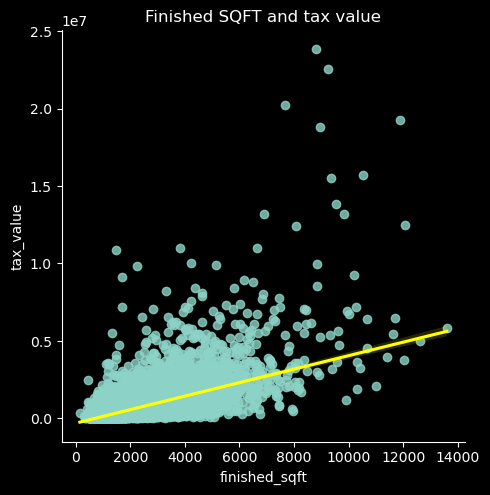

In [92]:
sns.lmplot(x='finished_sqft', y="tax_value", data=train, line_kws={'color': 'yellow'})
plt.title('Finished SQFT and tax value')
plt.show()

Text(0.5, 1.0, 'Distrobution of finished SQFT')

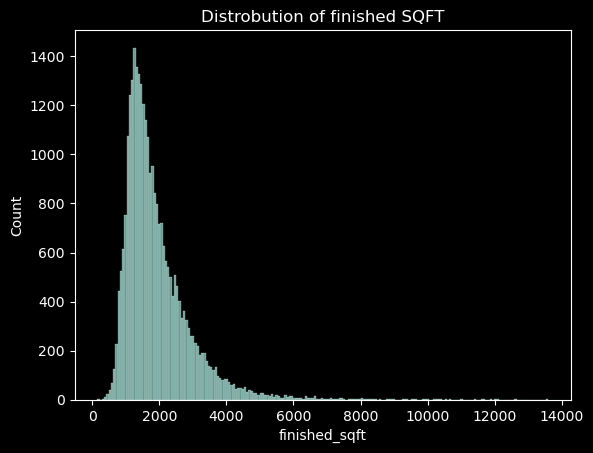

In [132]:
sns.histplot(data=train, x='finished_sqft')
plt.title('Distrobution of finished SQFT')

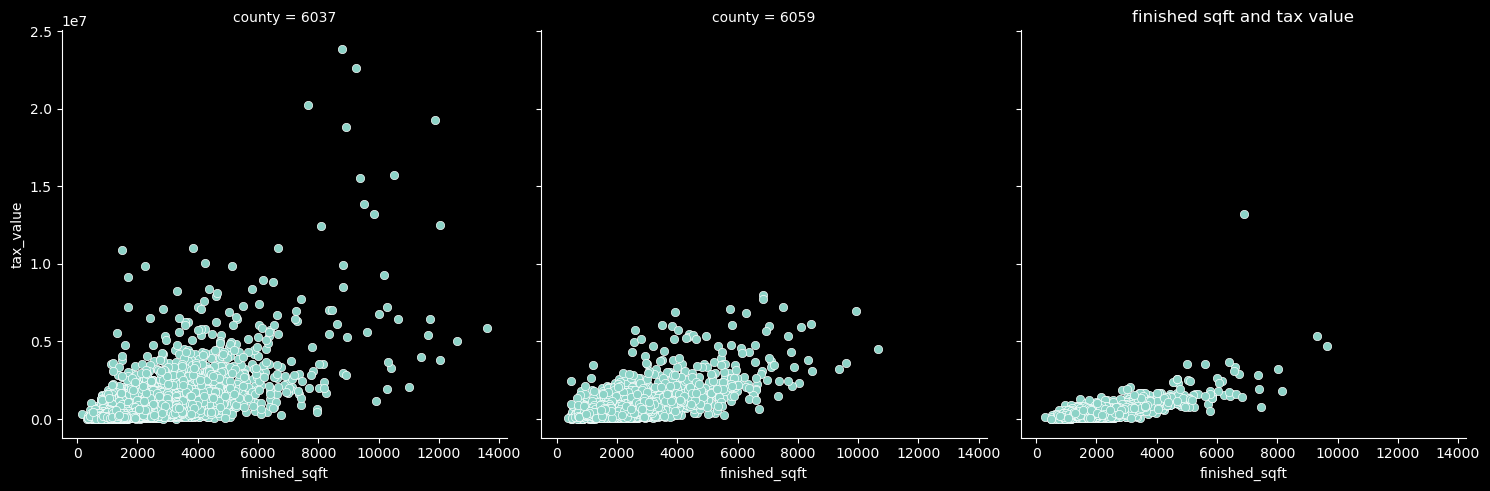

In [93]:
sns.relplot(x='finished_sqft', y="tax_value", data=train, col='county')
plt.title('finished sqft and tax value')
plt.show()

In [94]:
mean_sqft_per_county = train.groupby('county')['finished_sqft'].mean().reset_index()

mean_sqft_per_county


,county,finished_sqft
0,6037,1811.617176
1,6059,2114.333120
2,6111,2122.942667


# Stats Test 
    
    Null - there is no linear correlation between finished sqft and tax value 
    Alt - there is a linear correlation between finished sqft and tax value 

In [95]:
from scipy import stats # imports 

alpha = 0.05 # set the alpha 


corr, p = stats.pearsonr(train.tax_value, train.finished_sqft) # get the p value 
print(f'corr -> {corr}')
print(f'pvalue -> {p}')

if p < alpha: # compair p value our alpha value 
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

# Will be adding year built to my data dictionary 

corr -> 0.605176454174862
pvalue -> 0.0
We reject the null hypothesis


# Data Dictionary

|Feature|Discription|
| - | - |
|bed_rooms|Number of bed rooms|
|bath_rooms|Number of bathrooms|
|Finished_SQFT| usable space|
|year built|year the home was built| 



# Scale data 

In [96]:
from modeling import scale_train_data

mms = MinMaxScaler()
ss = StandardScaler() 
rs = RobustScaler()

columns_to_scale = ["bed_rooms", "bath_rooms", "finished_sqft", 'year_built']

train_scaled, validate_scaled, test_scaled = scale_train_data(
    train, validate, test, columns_to_scale, mms, return_scaler=False
)

train_scaled.head(3)

,propertylandusedesc,parcel_id,bed_rooms,bath_rooms,finished_sqft,tax_value,year_built,tax_amount,county,log_error,transaction_date
973119,Single Family Residential,12303159,0.125,0.000000,0.052655,116922,0.447761,1796.92,6037,-0.085598,2017-05-01
1890643,Single Family Residential,12188730,0.125,0.000000,0.030344,175322,0.298507,2257.09,6037,-0.150631,2017-04-24
1877305,Single Family Residential,17145380,0.125,0.111111,0.089766,493000,0.791045,6001.26,6111,0.032957,2017-06-02


# Modeling

In [97]:
from modeling import split_X

X_train, X_validate, X_test = split_X(train_scaled)

X_train.head(3) # verify 

,bed_rooms,bath_rooms,finished_sqft,year_built
973119,0.125,0.000000,0.052655,0.447761
1890643,0.125,0.000000,0.030344,0.298507
1877305,0.125,0.111111,0.089766,0.791045


In [98]:
from modeling import split_y

y_train, y_validate, y_test = split_y(train_scaled)

y_train[:10]

973119      116922
1890643     175322
1877305     493000
139781     3013405
516921      471567
207403       79309
1231738     904000
721052     1967515
1685593     390524
451867       49256
Name: tax_value, dtype: int64

# Baseline

In [99]:
baseline = y_train.mean()
baseline

#make an array to send into my mean_square_error function
baseline_array = np.repeat(baseline, len(train))
baseline_array[:5]

array([524953.68127735, 524953.68127735, 524953.68127735, 524953.68127735,
       524953.68127735])

In [100]:
from modeling import metrics_reg

rmse, r2 = metrics_reg(y_train, baseline_array)

metrics_df = pd.DataFrame(data=[{"model": "baseline", "rmse": rmse, "r2": r2}])
metrics_df

,model,rmse,r2
0,baseline,710769.614499,0.0


# Ordinary Least Squares (OLS)

In [101]:
#intial ML model
lr1 = LinearRegression()

#make it
rfe = RFE(lr1, n_features_to_select=4)

#fit it
rfe.fit(X_train, y_train)

#use it on train
X_train_rfe = rfe.transform(X_train)

#use it on validate
X_val_rfe = rfe.transform(X_validate)

In [102]:
print('selected top feature:', rfe.get_feature_names_out())

selected top feature: ['bed_rooms' 'bath_rooms' 'finished_sqft' 'year_built']


In [103]:
#fit the thing
lr1.fit(X_train_rfe, y_train)

#use the thing (make predictions)
pred_lr1 = lr1.predict(X_train_rfe)
pred_val_lr1 = lr1.predict(X_val_rfe)

In [104]:
#train
metrics_reg(y_train, pred_lr1)

(550105.8318194882, 0.40098900874555377)

In [105]:
#validate
rmse, r2 = metrics_reg(y_validate, pred_val_lr1)
rmse, r2

(550105.8318194882, 0.40098900874555377)

In [106]:
#add to my metrics df
metrics_df.loc[1] = ['ols_1', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,710769.614499,0.000000
1,ols_1,550105.831819,0.400989


# LassoLars

In [107]:
#make it
lars = LassoLars(alpha=1)

#fit it
lars.fit(X_train, y_train)

#use it
pred_lars = lars.predict(X_train)
pred_val_lars = lars.predict(X_validate)

In [108]:
#train
metrics_reg(y_train, pred_lars)

(550105.8325505714, 0.4009890071533986)

In [109]:
#validate
rmse, r2 = metrics_reg(y_validate, pred_val_lars)
rmse, r2

(550105.8325505714, 0.4009890071533986)

In [110]:
#add to my metrics df
metrics_df.loc[3] = ['lars', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,710769.614499,0.000000
1,ols_1,550105.831819,0.400989
3,lars,550105.832551,0.400989


# polynomial regression 

In [111]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

In [112]:
#make it
pr = LinearRegression()

#fit it
pr.fit(X_train_degree2, y_train)

#use it
pred_pr = pr.predict(X_train_degree2)
pred_val_pr = pr.predict(X_validate_degree2)

In [113]:
#train
metrics_reg(y_train, pred_pr)

(525214.3878541134, 0.45397123419466334)

In [114]:
#validate
rmse, r2 = metrics_reg(y_validate, pred_val_pr)
rmse, r2

(525214.3878541134, 0.45397123419466334)

In [115]:
#add to my metrics df
metrics_df.loc[4] = ['poly_2', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,710769.614499,0.000000
1,ols_1,550105.831819,0.400989
3,lars,550105.832551,0.400989
4,poly_2,525214.387854,0.453971


# Generalized Linear Model (GLM)

In [116]:
#make it
glm = TweedieRegressor(power=2, alpha=0)

#fit it
glm.fit(X_train, y_train)

#use it
pred_glm = glm.predict(X_train)
pred_val_glm = glm.predict(X_validate)

In [117]:
#train
metrics_reg(y_train, pred_glm)

(1855496.0873956408, -5.814945374154653)

In [118]:
#validate
rmse, r2 = metrics_reg(y_validate, pred_val_glm)
rmse, r2

(1855496.0873956408, -5.814945374154653)

In [119]:
metrics_df.loc[5] = ['glm',rmse,r2]
metrics_df

,model,rmse,r2
0,baseline,7.107696e+05,0.000000
1,ols_1,5.501058e+05,0.400989
3,lars,5.501058e+05,0.400989
4,poly_2,5.252144e+05,0.453971
5,glm,1.855496e+06,-5.814945


# Evaluate on the best model 

In [120]:
#use it
pred_test = pr.predict(X_test_degree2)
pred_test

array([254605.60126304, 219299.84109216, 434186.61583127, ...,
       364910.78068717, 319415.6932455 , 340307.25039516])

In [121]:
rmse, r2 = metrics_reg(y_test, pred_test)
rmse, r2

(525214.3878541134, 0.45397123419466334)

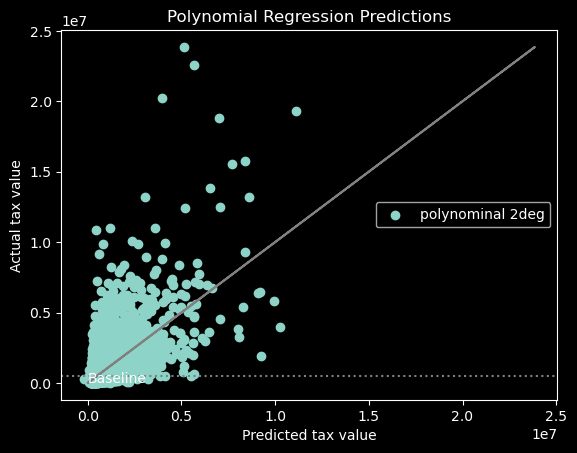

In [122]:
plt.scatter(pred_pr, y_train, label='polynominal 2deg')
plt.plot(y_train, y_train, label='_nolegend_', color='grey')

plt.axhline(baseline, ls=':', color='grey')
plt.annotate("Baseline", (65, 81))

plt.title("Polynomial Regression Predictions")
plt.ylabel("Actual tax value")
plt.xlabel("Predicted tax value")
plt.legend()

plt.show()

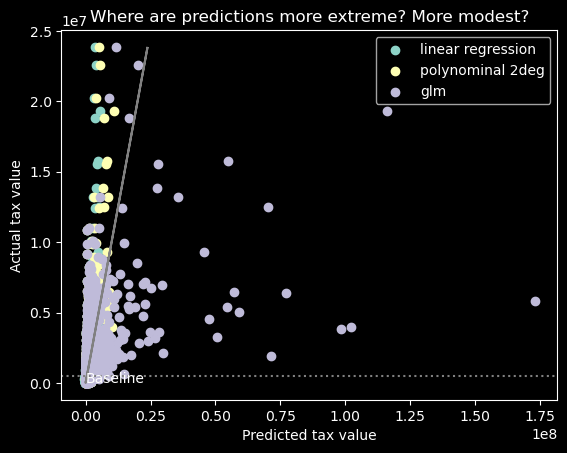

In [123]:
plt.scatter(pred_val_lr1, y_train, label='linear regression')
plt.scatter(pred_pr, y_train, label='polynominal 2deg')
plt.scatter(pred_glm, y_train, label='glm')
plt.plot(y_train, y_train, label='_nolegend_', color='grey')

plt.axhline(baseline, ls=':', color='grey')
plt.annotate("Baseline", (65, 81))

plt.title("Where are predictions more extreme? More modest?")
plt.ylabel("Actual tax value")
plt.xlabel("Predicted tax value")
plt.legend()

plt.show()

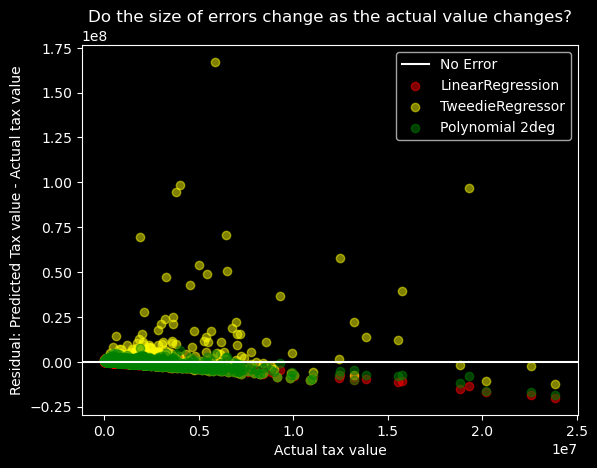

In [124]:
plt.axhline(label="No Error")

plt.scatter(y_train, pred_val_lr1 - y_train, alpha=.5, color="red", label="LinearRegression")
plt.scatter(y_train, pred_glm - y_train, alpha=.5, color="yellow", label="TweedieRegressor")
plt.scatter(y_train, pred_pr - y_train, alpha=.5, color="green", label="Polynomial 2deg ")

plt.legend()
plt.title("Do the size of errors change as the actual value changes?")
plt.xlabel("Actual tax value")
plt.ylabel("Residual: Predicted Tax value - Actual tax value")

plt.show()